#0. Install Dependencies

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install easyocr
!pip install imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 22.7 MB/s eta 0:00:00


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import easyocr

#Capture Image from Webcam

In [19]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def capture_video(filename='photo.jpg', quality=1.0):
    js = Javascript('''
    async function capturePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to make it easier to work with
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be pressed.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('capturePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Capture an image
image_path = capture_video()


<IPython.core.display.Javascript object>

#1. Read in image, Grayscale and Blur

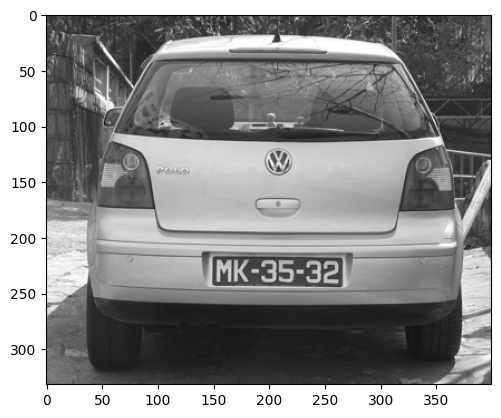

In [168]:
img = cv2.imread('/content/drive/MyDrive/PrivateProjects/P10 - ANPR/rqs/images/Cars116.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

#2. Apply filter and find edges for localization

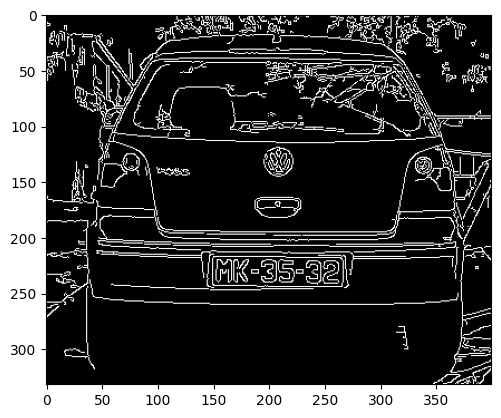

In [156]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise Reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge Detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

#3. Find Contours and Apply Mask

In [157]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [158]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break

In [159]:
location

array([[[149, 219]],

       [[263, 218]],

       [[266, 240]],

       [[151, 243]]], dtype=int32)

In [160]:
mask = np.zeros(gray.shape, np.uint8)
if location is not None:
  new_image = cv2.drawContours(mask, [location], 0,255, -1)
else:
  print('Could not find the location')
new_image = cv2.bitwise_and(img, img, mask=mask)

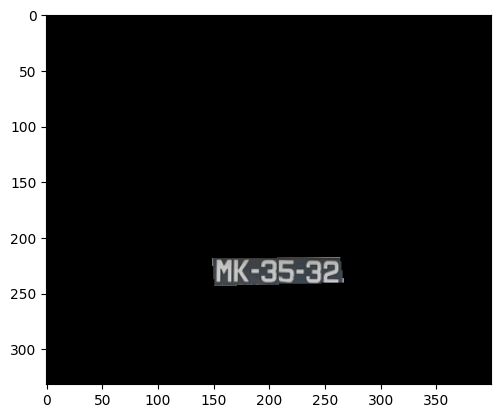

In [161]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

In [162]:
# Check if any pixels in the mask are 255 before finding min and max
if np.any(mask == 255):
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
else:
    print("No pixels with value 255 found in the mask. Cropping failed.")
    cropped_image = None

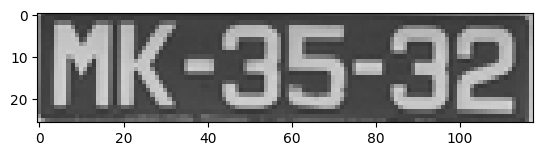

In [163]:
if cropped_image is not None:
  plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
else:
  print('try to capture another photo')

#4. Use Easy OCR To Read Text

In [164]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[0, 0], [118, 0], [118, 26], [0, 26]], 'MK-35-32', 0.9998859479338507)]

#5. Render Result

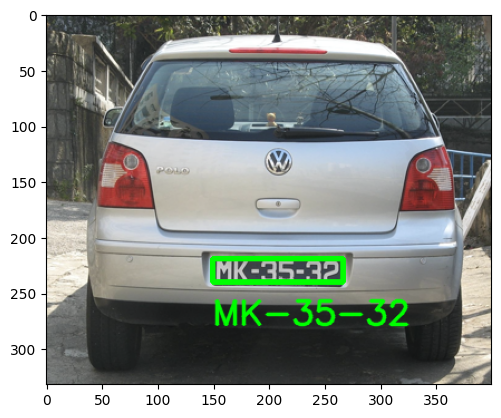

In [170]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60),
                  fontFace=font, fontScale=1, color=(0,255,0), thickness=2,
                  lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()